# Курсовой проект курса "Введение в нейронные сети"

**Описание источников данных:**  
https://www.kaggle.com/andrewmvd/animal-faces
    
**Задача:**  Классифицировать и научить модель различиать изображения собак, изображения кошек и изображения диких животных. 

train - данные для обучения модели: содержит 14630 изображений (5153 изображения кошек, 4739 изображений собак и 4738 изображений диких животных) для обучения модели.
val - тестовые данные: содержит 1500 изображений (500 изображений кошек, 500 изображений собак и 500 изображений диких животных) для тестирования модели.

**План проекта**
- [1. Знакомство с данными](#1)
- [2. Предобработка данных](#2)
- [3. Эксперименты с моделями](#3)
- [4. Валидация модели](#4)
- [5. Выводы по проекту](#5)

In [10]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator as imgen
from keras.models import Model
from keras.layers import GlobalAveragePooling2D,Dense,Dropout,Input
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input
from keras.callbacks import ModelCheckpoint,EarlyStopping

from sklearn.metrics import classification_report,confusion_matrix

from PIL import Image

**Generating Datasets**

In [11]:
traingen = imgen(preprocessing_function=preprocess_input,
                zoom_range=0.2,
                 shear_range=0.2,
                 horizontal_flip=True,
                 validation_split=0.12
                )
testgen = imgen(preprocessing_function=preprocess_input)

In [12]:
trainds = traingen.flow_from_directory("afhq/train",
                                      target_size=(128,128),
                                       seed = 123,
                                       batch_size=32,
                                       class_mode="categorical",
                                       subset="training"
                                      )
valds = traingen.flow_from_directory("afhq/train",
                                     target_size=(128,128),
                                      seed =123,
                                      batch_size = 32,
                                      class_mode="categorical",
                                      subset="validation"
                                     )
testds = testgen.flow_from_directory("afhq/val",
                                    target_size=(128,128),
                                      seed =123,
                                      batch_size = 32,
                                      class_mode="categorical",
                                     shuffle=False
                                    )

Found 12876 images belonging to 3 classes.
Found 1754 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


# 1. Знакомство с данными <a class='anchor' id=1>

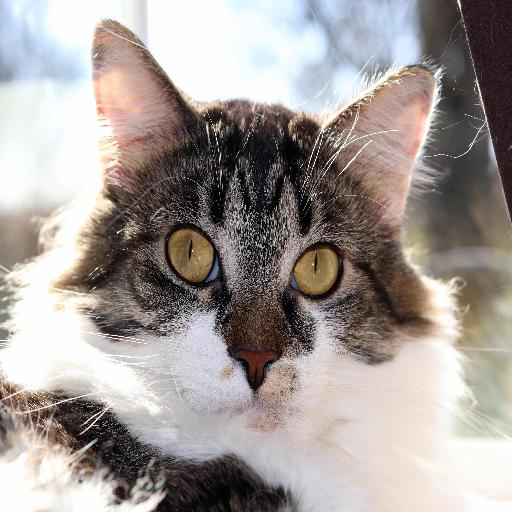

In [13]:
Image.open('afhq/train/cat/flickr_cat_000009.jpg')

**Class names and some visualizations**

In [14]:
classes = trainds.class_indices
classes = list(classes.keys())
classes

['cat', 'dog', 'wild']

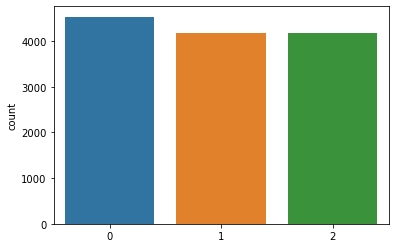

In [15]:
dist = trainds.classes
sns.countplot(x=dist);

# 2. Предобработка данных <a class='anchor' id=2>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

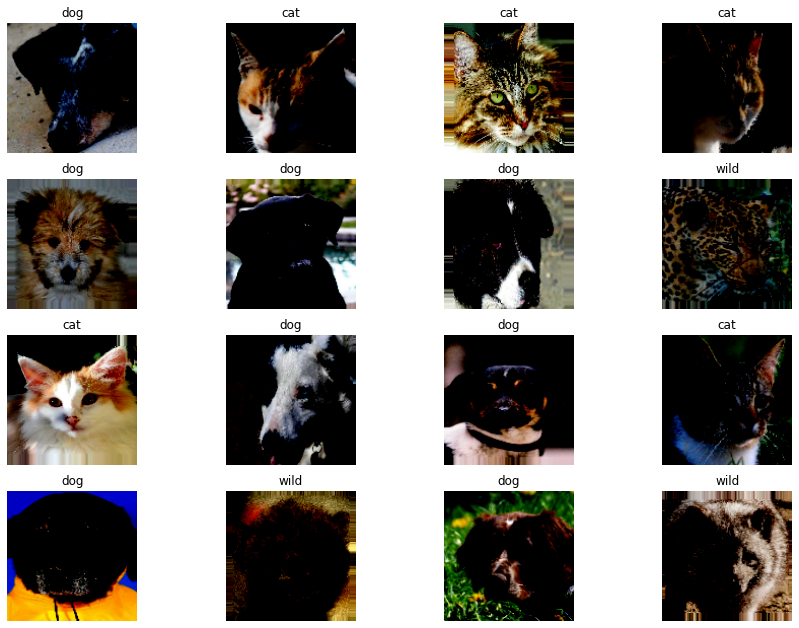

In [16]:
def showImages(x,y):
    plt.figure(figsize=[15,11])
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow(x[i])
        plt.title(classes[np.argmax(y[i])])
        plt.axis("off")
    plt.show()
    
x,y = next(trainds)
showImages(x,y)

# 3. Эксперименты с моделями <a class='anchor' id=3>

### **Model**

In [17]:
base_model = Xception(include_top = False,weights="imagenet",pooling="avg",input_shape=(128,128,3))

base_model.trainable = False

In [18]:
image_input = Input(shape=(128,128,3))
x = base_model(image_input,training = False)
x = Dense(128,activation = "relu")(x)
image_output = Dense(3,activation="softmax")(x)
model = Model(image_input,image_output)

In [19]:
# compile
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

# callbacks
my_calls = [EarlyStopping(monitor="val_accuracy",patience=3),
            ModelCheckpoint("Model.h5",verbose= 1 ,save_best_only=True)]

**Train**

In [20]:
hist = model.fit(trainds, epochs=15, validation_data=valds, callbacks=my_calls)

Epoch 1/15
403/403 [==============================] - 362s 887ms/step - loss: 0.0696 - accuracy: 0.9729 - val_loss: 0.0213 - val_accuracy: 0.9926

Epoch 00001: val_loss improved from inf to 0.02129, saving model to Model.h5
Epoch 2/15
403/403 [==============================] - 360s 894ms/step - loss: 0.0150 - accuracy: 0.9952 - val_loss: 0.0243 - val_accuracy: 0.9920

Epoch 00002: val_loss did not improve from 0.02129
Epoch 3/15
403/403 [==============================] - 338s 838ms/step - loss: 0.0129 - accuracy: 0.9959 - val_loss: 0.0183 - val_accuracy: 0.9926

Epoch 00003: val_loss improved from 0.02129 to 0.01831, saving model to Model.h5
Epoch 4/15
403/403 [==============================] - 335s 831ms/step - loss: 0.0084 - accuracy: 0.9975 - val_loss: 0.0228 - val_accuracy: 0.9932

Epoch 00004: val_loss did not improve from 0.01831
Epoch 5/15
403/403 [==============================] - 335s 831ms/step - loss: 0.0108 - accuracy: 0.9964 - val_loss: 0.0273 - val_accuracy: 0.9892

Epoch

# 4. Валидация модели <a class='anchor' id=4>

**Test**

In [21]:
model.evaluate(testds)

47/47 [==============================] - 34s 728ms/step - loss: 0.0422 - accuracy: 0.9913


[0.04219125211238861, 0.9913333058357239]

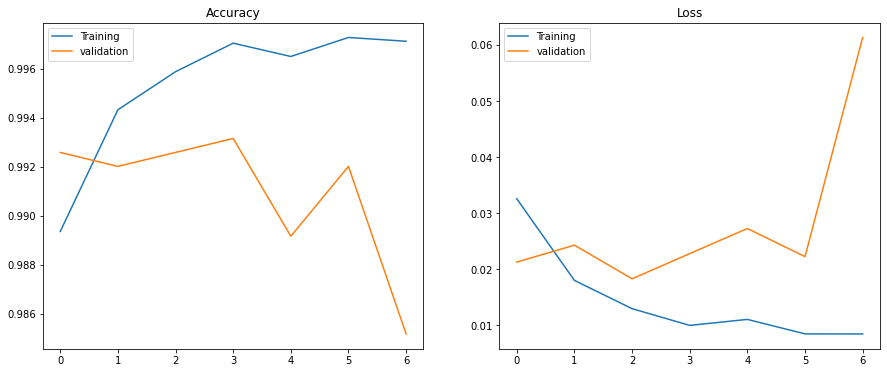

In [22]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(hist.epoch,hist.history['accuracy'],label = 'Training')
plt.plot(hist.epoch,hist.history['val_accuracy'],label = 'validation')

plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.epoch,hist.history['loss'],label = 'Training')
plt.plot(hist.epoch,hist.history['val_loss'],label = 'validation')

plt.title("Loss")
plt.legend()
plt.show()

**Predictions**

In [23]:
pred = model.predict(testds,verbose=1)

47/47 [==============================] - 35s 715ms/step


In [24]:
pred = [np.argmax(i) for i in pred]

In [25]:
y_test = testds.classes

In [26]:
print(classification_report(pred,y_test))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       506
           1       0.99      1.00      0.99       498
           2       0.98      0.99      0.99       496

    accuracy                           0.99      1500
   macro avg       0.99      0.99      0.99      1500
weighted avg       0.99      0.99      0.99      1500



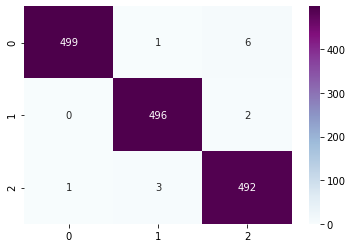

In [27]:
sns.heatmap(confusion_matrix(pred,y_test),annot = True, fmt = "d", cmap = "BuPu");

# 5. Выводы по проекту <a class='anchor' id=5>

В рамках задачи классифицировать и научить модель различиать изображения собак, изображения кошек и изображения диких животных достигнут высокий accuracy и низкий loss.

Как вариант перспективы можно определять accuracy и loss у каждого изображения по отдельности.